# Compare Twitter and Reddit Populations

## Analyis of Shared Text

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform in terms of the **text** they share.

The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [2]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
# def convert_date(date):
#     return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

# def convert_time(timestamp):
#     created_time = timestamp
#     if ( isinstance(created_time, str) ):
#         created_time = float(created_time)
        
#     d = datetime.datetime.utcfromtimestamp(created_time)
#     return d

# def get_top_tlds(links_df, user_id_field, top_n=100):
#     tld_user_counts = {}
#     for tld, group in links_df.groupby("tld"):
#         local_users = set(group[user_id_field])
#         tld_user_counts[tld] = len(local_users)

#     return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

# def links_df_to_shares(links_df, domains, user_id_field):
#     user_shares = []

#     for user,user_posts in links_df.groupby(user_id_field):
#         local_tld_counts = dict(user_posts["tld"].value_counts().items())
#         local_vector = [local_tld_counts.get(x, 0) for x in domains]
#         user_shares.append([user] + local_vector)

#     return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

# def links_to_norm_matrix(links_df, domains, user_id_field):
#     if ( type(domains) == set ):
#         domains = list(domains)
        
#     shares_df = links_df_to_shares(links_df, domains, user_id_field)
#     return sklearn.preprocessing.normalize(shares_df[domains], norm="l2", axis=1)

# def get_top_channels(yt_df, user_id_field, top_n=100):
#     channel_user_counts = {}
#     for channel, group in yt_df.groupby("channel_id"):
#         local_users = set(group[user_id_field])
#         channel_user_counts[channel] = len(local_users)

#     return sorted(channel_user_counts, key=channel_user_counts.get, reverse=True)[:top_n]

# def channels_df_to_shares(links_df, channels, user_id_field):
#     user_shares = []

#     for user,user_posts in links_df.groupby(user_id_field):
#         local_chan_counts = dict(user_posts["channel_id"].value_counts().items())
#         local_vector = [local_chan_counts.get(x, 0) for x in channels]
#         user_shares.append([user] + local_vector)

#     return pd.DataFrame(user_shares, columns=[user_id_field] + channels)

# def channels_to_norm_matrix(links_df, channels, user_id_field):
#     if ( type(channels) == set ):
#         channels = list(channels)
        
#     shares_df = channels_df_to_shares(links_df, channels, user_id_field)
#     return sklearn.preprocessing.normalize(shares_df[channels], norm="l2", axis=1)


In [5]:
bootstrap_count = 5000

In [6]:
twitter_links_df_rand = pd.read_csv("twitter_random_sample_user_means.csv")
twitter_links_df_poli = pd.read_csv("twitter_political_sample_user_means.csv")
twitter_links_df_ira = pd.read_csv("twitter_ira_sample_user_means.csv")

In [8]:
reddit_links_df_rand = pd.read_csv("reddit_random_sample_user_means.csv")
reddit_links_df_poli = pd.read_csv("reddit_political_sample_user_means.csv")
reddit_links_df_ira = pd.read_csv("reddit_ira_sample_user_means.csv")

In [24]:
def df_to_matrix(local_df):
    
    users = local_df['0']
    mat = local_df[[str(x) for x in range(1,local_df.shape[1])]].to_dense()
    
    return (users, mat)

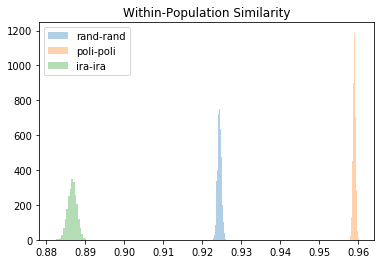

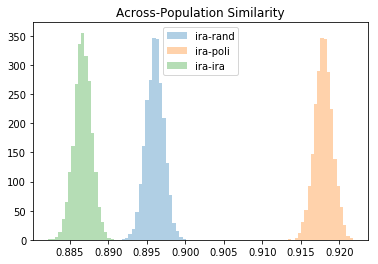

In [35]:
u_rand, twitter_user_links_mat_rand = df_to_matrix(twitter_links_df_rand)
u_poli, twitter_user_links_mat_poli = df_to_matrix(twitter_links_df_poli)
u_ira, twitter_user_links_mat_ira = df_to_matrix(twitter_links_df_ira)

# t2t_rand_rand_dist = sklearn.metrics.pairwise.euclidean_distances(
#     twitter_user_links_mat_rand, twitter_user_links_mat_rand)


# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_ira, twitter_user_links_mat_rand)
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_ira, twitter_user_links_mat_poli)
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_rand, twitter_user_links_mat_poli)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [36]:
print("Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), np.array(t2t_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), np.array(t2t_ira_ira_sim_avg_bootstrap).var())


Random: 0.9244075379368686 2.584519018796219e-07
Political: 0.9589441550071164 1.1414958467744623e-07
Russian IRA: 0.886704607353652 1.3123490468503376e-06


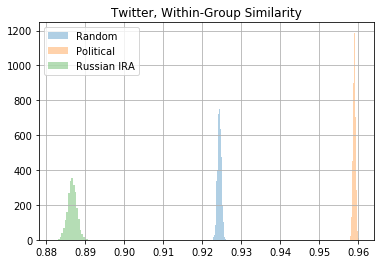

In [37]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA")

plt.title("Twitter, Within-Group Similarity")
plt.legend()
plt.grid()
plt.show()

In [38]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 11619442.848469513
p-value for Welch's t-Test between Rand and IRA: 0.0 2126.944214609345
p-value for Welch's t-Test between Poli and IRA: 0.0 4276.425460749996


In [39]:
print("Random-Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.9244075379368686 2.584519018796219e-07
Russian IRA-Random: 0.8960504484540417 1.3572685002082246e-06
Russian IRA-Political: 0.9179415932215439 1.3710163033677457e-06


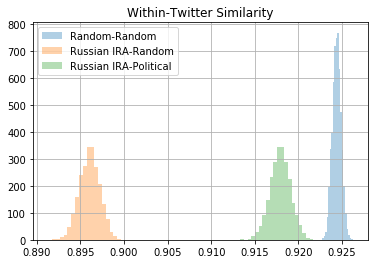

In [40]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [41]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 1108978.0284059902
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -937.0552309087274


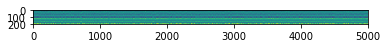

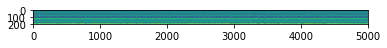

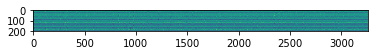

In [42]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

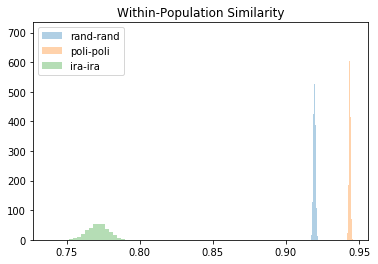

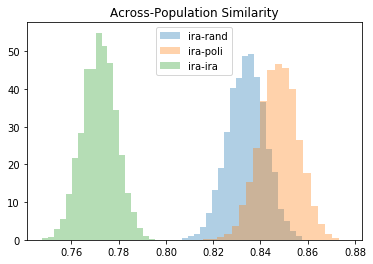

In [43]:
u_rand, reddit_user_links_mat_rand = df_to_matrix(reddit_links_df_rand)
u_poli, reddit_user_links_mat_poli = df_to_matrix(reddit_links_df_poli)
u_ira, reddit_user_links_mat_ira = df_to_matrix(reddit_links_df_ira)

# r2r_rand_rand_dist = sklearn.metrics.pairwise.euclidean_distances(
#     reddit_user_links_mat_rand, reddit_user_links_mat_rand)


# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_ira, reddit_user_links_mat_rand)
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_ira, reddit_user_links_mat_poli)
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_rand, reddit_user_links_mat_poli)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [44]:
print("Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), np.array(r2r_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), np.array(r2r_ira_ira_sim_avg_bootstrap).var())


Random: 0.919499111671321 5.396554562290597e-07
Political: 0.9436713162560374 3.1127033641638817e-07
Russian IRA: 0.7717600356613963 5.182691844937717e-05


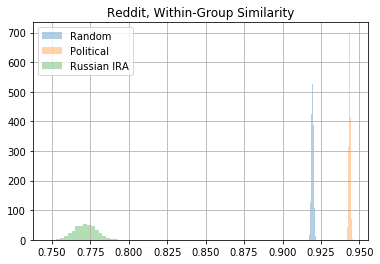

In [45]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA")

plt.title("Reddit, Within-Group Similarity")
plt.legend()
plt.grid()
plt.show()

In [46]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 2465658.298774144
p-value for Welch's t-Test between Rand and IRA: 0.0 1443.4769935557526
p-value for Welch's t-Test between Poli and IRA: 0.0 1683.3250011146147


In [47]:
print("Random-Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())



Random-Random: 0.919499111671321 5.396554562290597e-07
Russian IRA-Random: 0.8339255263962801 6.26811005292929e-05
Russian IRA-Political: 0.8477458893518307 6.6048058378085e-05


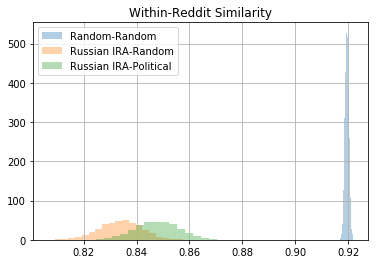

In [48]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [49]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 244835.4119946534
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -86.12367458895585


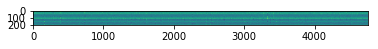

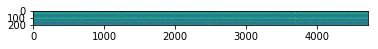

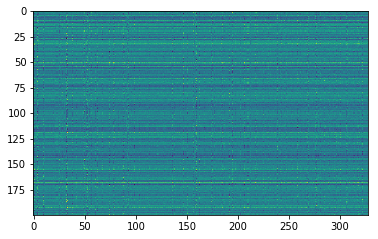

In [50]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

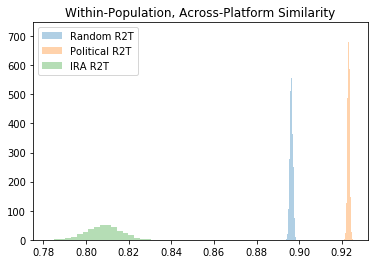

In [51]:
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_rand, twitter_user_links_mat_rand)
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_poli, twitter_user_links_mat_poli)
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    reddit_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [52]:
print("Random-R2T:", np.array(r2t_rand_sim_avg_bootstrap).mean(), np.array(r2t_rand_sim_avg_bootstrap).var())
print("Political-R2T:", np.array(r2t_poli_sim_avg_bootstrap).mean(), np.array(r2t_poli_sim_avg_bootstrap).var())
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())



Random-R2T: 0.8962957843625067 4.863354120109772e-07
Political-R2T: 0.9231701379784834 3.149743939797016e-07
Russian IRA-R2T: 0.8085604436367189 6.04601875844174e-05


In [53]:
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())
print("Russian IRA-RRandom:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-RPoli:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Russian IRA-R2T: 0.8085604436367189 6.04601875844174e-05
Russian IRA-RRandom: 0.8339255263962801 6.26811005292929e-05
Russian IRA-RPoli: 0.8477458893518307 6.6048058378085e-05


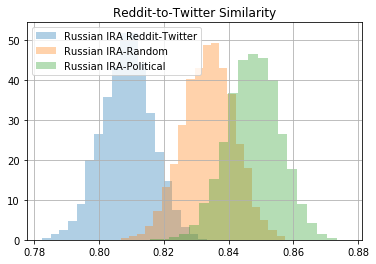

In [54]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Reddit-Twitter")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Reddit-to-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [55]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 31310.101198206143
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 -161.61289350917048
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 -246.3241213148891


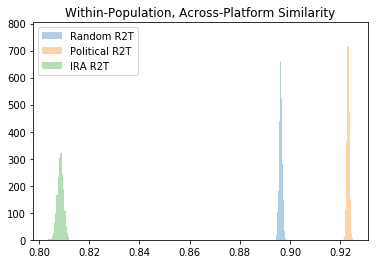

In [56]:
t2r_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_rand, reddit_user_links_mat_rand)
t2r_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_poli, reddit_user_links_mat_poli)
t2r_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    twitter_user_links_mat_ira, reddit_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
t2r_rand_sim_avg = np.mean(t2r_rand_sim, axis=1)
t2r_poli_sim_avg = np.mean(t2r_poli_sim, axis=1)
t2r_ira_sim_avg = np.mean(t2r_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
t2r_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2r_rand_sim_avg, replace=True, n_samples=t2r_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2r_poli_sim_avg, replace=True, n_samples=t2r_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2r_ira_sim_avg, replace=True, n_samples=t2r_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2r_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(t2r_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



In [57]:
print("Russian IRA-T2R:", np.array(t2r_ira_sim_avg_bootstrap).mean(), np.array(t2r_ira_sim_avg_bootstrap).var())
print("Russian IRA-TRandom:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-TPoli:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Russian IRA-T2R: 0.8085264713790705 1.4631298208888594e-06
Russian IRA-TRandom: 0.8960504484540417 1.3572685002082246e-06
Russian IRA-TPoli: 0.9179415932215439 1.3710163033677457e-06


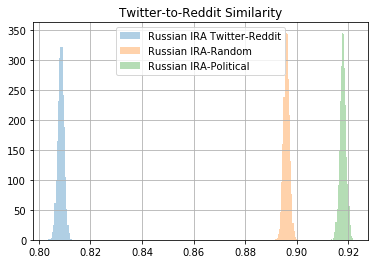

In [58]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Twitter-Reddit")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Twitter-to-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [59]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 11993155.774398869
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 -3684.7954838550213
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 -4595.235757424071


In [60]:
## Full Cross-Comparison

### Other comparisons
t2t_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_poli_sim_avg, replace=True, n_samples=t2t_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_poli_sim_avg, replace=True, n_samples=r2r_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]




In [61]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)


	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: 0.919499111671321 5.396554562290597e-07 0.9280973717867274 5.630225018356363e-07 0.8339255263962801 6.26811005292929e-05 0.8962957843625067 4.863354120109772e-07
Political: 0.9280973717867274 5.630225018356363e-07 0.9436713162560374 3.1127033641638817e-07 0.8477458893518307 6.6048058378085e-05 0.9231701379784834 3.149743939797016e-07
IRA: 0.8339255263962801 6.26811005292929e-05 0.8477458893518307 6.6048058378085e-05 0.7717600356613963 5.182691844937717e-05 0.8085604436367189 6.04601875844174e-05
Twitter
Random: 0.9244075379368686 2.584519018796219e-07 0.9302023394559299 4.62917936272209e-07 0.8960504484540417 1.3572685002082246e-06 0.8962899384017193 3.762771574532509e-07
Political: 0.9302023394559299 4.62917936272209e-07 0.9589441550071164 1.1414958467744623e-07 0.9179415932215439 1.3710163033677457e-06 0.9231684286762416 2.608900050341199e-07
IRA: 0.8960504484540417 1.3572685002082246e-

### Compare Identically Named Users

In [ ]:
reddit_troll_names = pd.read_csv("../data/reddit_troll_accounts_20190206.csv")
twitter_troll_names = pd.read_csv("../data/twitter_russian_troll_accounts.csv")

In [ ]:
cross_platform_users = set(twitter_troll_names["handle"].apply(str.lower))\
    .intersection(set(reddit_troll_names["username"].apply(str.lower)))

print("User count with the same ID:", len(cross_platform_users))
for u in cross_platform_users:
    print(u)

In [ ]:
deanon_df = pd.read_csv("../data/deanon_v2.csv")

In [ ]:
deanon_map = {row["screen_name"].lower():row["userid"] for _, row in deanon_df.iterrows()}

In [ ]:
for u in cross_platform_users:
    print(u, deanon_map.get(u))
    

In [ ]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    print(u, deanon_map.get(u))
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)
    print("\t", "Twitter TLDs:", len(local_twitter_tld), "Reddit TLDs:", len(local_reddit_tld))
    print("\t", "TLDs in Common:", len(common_tlds))

    if ( len(common_tlds) == 0 ):
        continue
        
    local_sim = sklearn.metrics.pairwise.cosine_similarity(
        links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
        links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
    print("\t", "Local Similarity:", local_sim)

In [ ]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)

    sim = 0.0
    if ( len(common_tlds) > 0 ):
        local_sim = sklearn.metrics.pairwise.cosine_similarity(
            links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
            links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
        sim = local_sim[0]
        
    print("%s & %d & %d & %d & %f \\\\" % (u, len(local_reddit_tld), len(local_twitter_tld), len(common_tlds), sim))
    